In [2]:
from NetClasses import *
from SobolevClasses import *
import pandas as pd

2024-06-04 15:45:33.673475: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Attempt to use neural networks to approximate functions in the Discrete Sobolev Space

## What we want to show

$$
\left\| f - \sum_{j=1}^{n} a_j(f) \varphi(A_j(\cdot) + b)  \right\|_p \leq c n^{-r/s} \left\| f \right\|_{W_{r,s}^{p}}
$$

i.e. the neural network can approximate the function in the Sobolev space with a rate of $n^{-r/s}$ w.r.t the Lp norm.

### Notation
- $r$ : smoothness of the function in the Sobolev space
- $p$ : $L^p$ norm to be used
- $s$ : dimension of the input space

### Test 1: f(x) = sin(x)
### 1 input, 1 output

In [18]:
def RunSobolevTest(f,n_inputs=1,n_outputs=1,n_samples=1000):
    """
    Input: f a function
    Output: Graph of final loss of varying width shallow networks
    """

    # Create Dataset Generator
    gen_func = FunctionSamples(lambda x: f(x), n_samples=100, n_inputs=n_inputs, n_outputs=n_outputs)
    ds = gen_func.get_dataset()

    def Lp_loss(y_true, y_pred, p=2):
        if p < 1:
            raise ValueError("p must be greater than or equal to 1")
        
        # Calculate the absolute difference raised to the power of p
        difference_power_p = abs(y_true - y_pred) ** p
        
        # Take the p-th root of the result
        return difference_power_p ** (1/p)

    # Run 20 trials and average the results
    N = np.arange(0, 2600, 200)
    # Create empty dataframe to store results
    results = pd.DataFrame(columns=['N', 'Loss'])
    for i in range(20):
        # Create the network
        for n in tqdm(N, desc=f"Trial {i}"):
            net = ShallowNetwork(1,n,1).build_model()
            ds = gen_func.get_dataset()

            net.compile(optimizer='adam', loss=Lp_loss)
            net.fit(ds, epochs=20, verbose=0)
            loss = net.evaluate(ds, verbose=0)
            results = pd.concat([results, pd.DataFrame({'N': [n], 'Loss': [loss]})])
            print(f"n: {n}, loss: {loss}")

    results.to_csv(f"SobolevTest_{f.__name__}.csv")
    # Average the results
    results = results.groupby('N').mean()
    results.plot()
    plt.title(f"Sobolev Test for {f.__name__}")
    plt.xlabel("Width of Network")
    plt.ylabel("Loss")
    plt.yscale('log')
    plt.show()

In [ ]:
# Run test for f(x) = exp(-x^2)
RunSobolevTest(lambda x: np.exp(-x**2))



### Piecewise linear splins

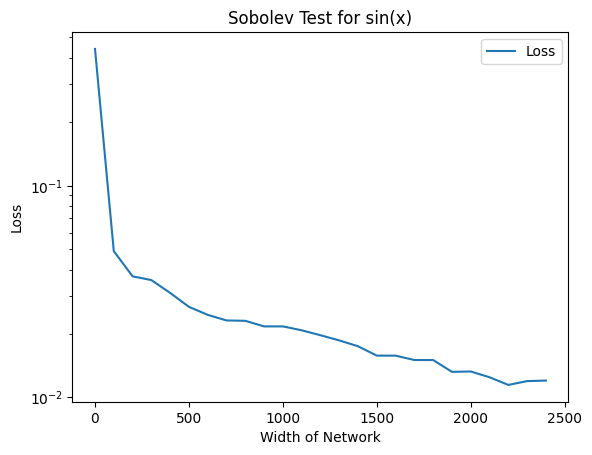

In [2]:
# Read in the results
results = pd.read_csv("SobolevTest_sin.csv")
# Remove 1st column
results = results.iloc[:,1:]
results = results.groupby('N').mean()
results.plot()
plt.title("Sobolev Test for sin(x)")
plt.xlabel("Width of Network")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

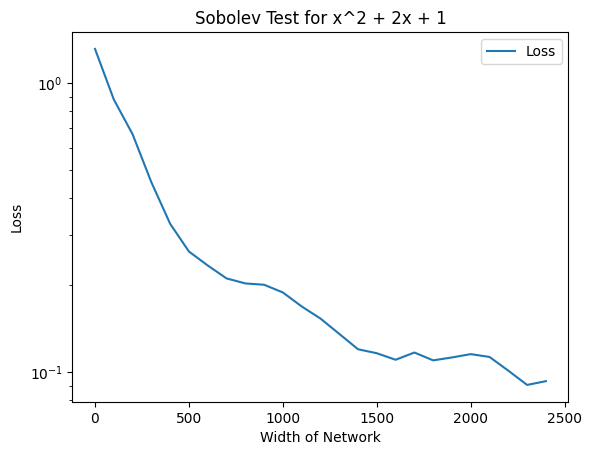

In [7]:
# Read in the results
results = pd.read_csv("SobolevTest_poly.csv")
# Remove 1st column
results = results.iloc[:,1:]
results = results.groupby('N').mean()
results.plot()
plt.title("Sobolev Test for x^2 + 2x + 1")
plt.xlabel("Width of Network")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

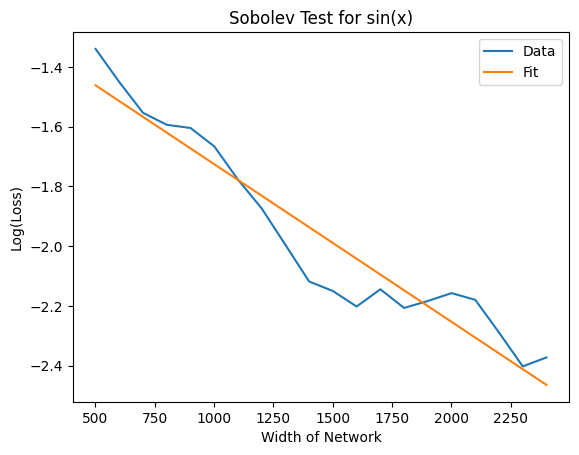

m: -0.0005278639043839414, b: -1.1970584651062102
Expected m: -r/s = -2/1000
log-Norm of sin(x): 0.4676346829397979


In [6]:
# Fit a line to the log-data with index > 500
log_results = np.log(results)
log_results = log_results[log_results.index > 500]

# Fit a line to the log-data
m, b = np.polyfit(log_results.index, log_results['Loss'], 1)
plt.plot(log_results.index, log_results['Loss'], label='Data')
plt.plot(log_results.index, m*log_results.index + b, label='Fit')
plt.title("Sobolev Test for sin(x)")
plt.xlabel("Width of Network")
plt.ylabel("Log(Loss)")
plt.legend()
plt.show()
print(f"m: {m}, b: {b}")

# Expected m
print(f"Expected m: -r/s = -2/1000")
# Norm of sin(x)
domain = [(-1,1)]
grid_resolution = [1000]
DSobolevSpace = DiscreteSobolevSpace(domain, grid_res = grid_resolution, r=2, p=2)
norm = DSobolevSpace.norm(lambda x: np.sin(x))
print(f"log-Norm of sin(x): {np.log(norm)}")

In [6]:
gen_discrete_sin = FunctionSamples(lambda x: np.sin(x), n_samples=10000, n_inputs=1,n_outputs=1)
ds = gen_discrete_sin.get_dataset()

In [13]:
N = [10,50] + list(range(100,2000,200)) + list(range(2000,16000,1000))

def Lp_loss(y_true, y_pred, p=2):
    if p < 1:
        raise ValueError("p must be greater than or equal to 1")
    
    # Calculate the absolute difference raised to the power of p
    difference_power_p = abs(y_true - y_pred) ** p
    
    # Take the p-th root of the result
    return difference_power_p ** (1/p)


In [ ]:
for i in range(10):
    with open("data/sobolev_sin_{}.csv".format(i+1), "w") as f:
        f.write("N,loss\n")
        print("Iteration", i)
        # losses = []
        for n in tqdm(N):
            print(n)
            net = ShallowNetwork(1,n,1).build_model()
            ds = gen_discrete_sin.get_dataset()

            net.compile(optimizer='adam', loss=Lp_loss)
            history = net.fit(ds, epochs=50, verbose=0, batch_size=100)
            with open ("data/sobolev_sin_{}.csv".format(i), "a") as f:
                f.write("{},{}\n".format(n, net.evaluate(ds, verbose=0)))
            print("Loss:", net.evaluate(ds, verbose=0))

In [ ]:
# Read all the data and average it
df = pd.read_csv("data/sobolev_sin_0.csv")
for i in range(1,10):
    df = df.add(pd.read_csv("data/sobolev_sin_{}.csv".format(i)), fill_value=0)

df = df / 10
# Plot the data
plt.plot(df["N"], df["loss"])
plt.xlabel("Number of neurons")
plt.ylabel("Loss")
plt.title("Sobolev sin(x) function")
plt.show()

In [ ]:
with open('shallow_losses.csv', 'w') as f:
    f.write('n,loss\n')
shallow_losses = []
for n in tqdm(N):
    model = ShallowNetwork(1,n,1).build_model()
    ds = gen_discrete_sin.get_dataset()

    model.compile(optimizer='adam', loss=Lp_loss)
    history = model.fit(ds, epochs = 50, verbose=0, batch_size=100)
    shallow_losses.append(model.evaluate(ds, verbose=0))
    with open('shallow_losses.csv', 'a') as f:
        f.write(str(n) + ',' + str(shallow_losses[-1]) + '\n')

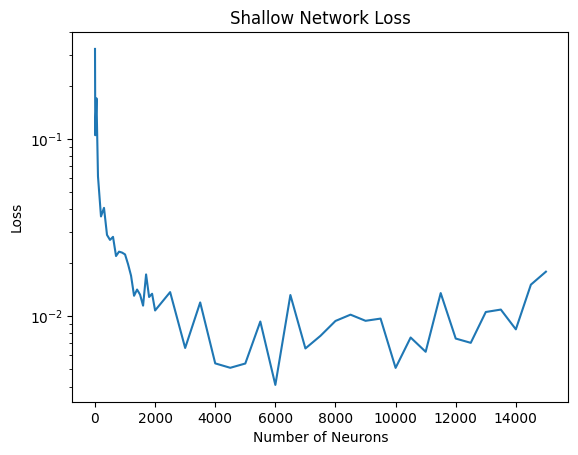

In [21]:
# Read the data back in and plot it
shallow_losses = pd.read_csv('shallow_losses.csv')
plt.plot(shallow_losses['n'], shallow_losses['loss'])
plt.xlabel('Number of Neurons')
plt.ylabel('L2 - Loss')
plt.yscale('log')
plt.title('Shallow Network Loss')
plt.show()

In [ ]:
domain = [(0, 2*np.pi)]
r = 2
p = 2
grid_res = [100]

DSobolevSpace = DiscreteSobolevSpace(domain=domain, r=2, p=2, grid_res=grid_res)

def f(x):
    return np.sin(x)

print("Discrete Sobolev Norm of sin(x):", DSobolevSpace.norm(f))

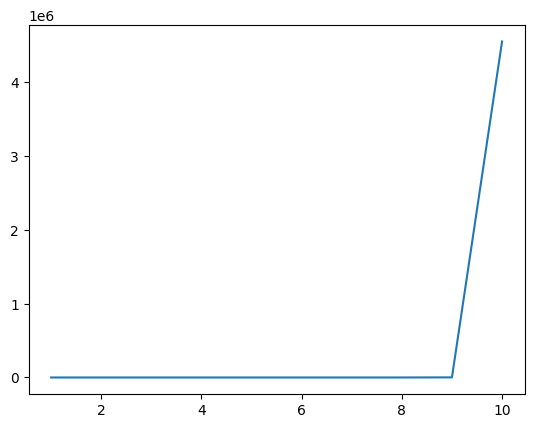

In [6]:
# Find norm for increasing r
r = np.arange(1, 11)
grid_res = [100]
def f(x):
    return np.sin(x)

norms = []
for r_val in r:
    DSobolevSpace = DiscreteSobolevSpace(domain=domain, r=r_val, p=2, grid_res=grid_res)
    norms.append(DSobolevSpace.norm(f))

plt.plot(r, norms)